# Telco Churn: Predictive Classification Model

## 1. Project Goal
The goal of this project is to build and evaluate a classification model to accurately predict which customers are likely to churn. This model will be built upon the key insights discovered in our comprehensive Exploratory Data Analysis (EDA).

## 2. Foundation: Insights from EDA
The full EDA can be found in `Telco_Churn_EDA.ipynb`. The analysis identified several key drivers of churn, including `contract` type, `tenure`, and `internetservice`. These findings will guide our feature selection. This notebook begins with the fully cleaned dataset generated by the EDA.

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
# from google.colab import drive

# Mount Drive and path utilities folder
# drive.mount('/content/drive')
utils_path = '../utils'
sys.path.append(utils_path)
import ml_utils


# --- 2. LOAD CLEAN DATA ---
file_path = './data/telco_churn_cleaned.csv'
df_clean = pd.read_csv(file_path)

print("Clean data loaded successfully.")
print(f"Shape of the dataset: {df_clean.shape}")
df_clean.head()

Clean data loaded successfully.
Shape of the dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df_clean.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## 3. Data Preparation for Classification Modeling

With our clean dataset loaded, we now need to prepare it specifically for a classification task. This involves several key steps:

1.  **Target Variable Transformation:** Our target `churn` is currently a string ('Yes'/'No'). Machine learning models require a numerical input, so we will convert this to a binary format (1 for 'Yes', 0 for 'No').
2.  **Feature Selection:** As discussed in our EDA and strategic plan, we will create two distinct sets of features. This allows us to build and compare a simple, interpretable baseline model with a more complex, high-performance model.
3.  **Handling Feature Dependencies:** We'll explicitly acknowledge the redundancy in the service add-on features and use that to inform our feature selection for the baseline model.

Let's start by defining our target variable and feature sets.

In [3]:
# --- 1. Standardize Column Names (Robust Method) ---
# Start with a simple lowercase conversion
df_clean.columns = [col.lower() for col in df_clean.columns]

# Now, handle specific cases and general patterns
# Create a dictionary for renaming
rename_dict = {
    'customerid': 'customer_id',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies',
    'paperlessbilling': 'paperless_billing',
    'paymentmethod': 'payment_method',
    'seniorcitizen': 'senior_citizen',
    'phoneservice': 'phone_service',
    'multiplelines': 'multiple_lines'
}
df_clean.rename(columns=rename_dict, inplace=True)


# --- 2. Define and Transform the Target Variable (y) ---
# We map 'Yes' to 1 and 'No' to 0.
df_clean['churn'] = df_clean['churn'].map({'Yes': 1, 'No': 0})
y = df_clean['churn']


# --- 3. Feature Selection ---

# Now we can safely drop the correctly named 'customer_id' column
X_base = df_clean.drop(columns=['customer_id', 'churn'])

# -- Set 1: Curated Features for the Interpretable Baseline Model (Logistic Regression) --
features_for_baseline = [
    'tenure',
    'monthly_charges',
    'total_charges',
    'contract',
    'internet_service',
    'online_security',
    'tech_support',
    'paperless_billing'
]
X_baseline = X_base[features_for_baseline]


# -- Set 2: All Features for the High-Performance Model (XGBoost) --
X_advanced = X_base


# --- 4. Identify Numerical and Categorical Features for each set ---
num_features_baseline = X_baseline.select_dtypes(include=np.number).columns.tolist()
cat_features_baseline = X_baseline.select_dtypes(include='object').columns.tolist()

num_features_advanced = X_advanced.select_dtypes(include=np.number).columns.tolist()
cat_features_advanced = X_advanced.select_dtypes(include='object').columns.tolist()


# --- 5. Verification ---
print("--- Cleaned Column Names (Sample) ---")
print(df_clean.columns) # Show all to confirm

print("\n--- Baseline Feature Set ---")
print(f"Shape: {X_baseline.shape}")

--- Cleaned Column Names (Sample) ---
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

--- Baseline Feature Set ---
Shape: (7043, 8)


## 4. Building the Modeling Pipeline

Now that we have our data prepared, we will split it into training and testing sets. It is crucial that all subsequent steps, including handling class imbalance with SMOTE and preprocessing, are performed **only on the training data** to prevent data leakage and ensure an unbiased evaluation of our models.

### 4.1 Train-Test Split

We will perform a standard 80/20 split on both our baseline and advanced feature sets.

In [4]:
# --- Perform Train-Test Split for BOTH feature sets ---

# Baseline Split
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42, stratify=y # stratify=y is crucial for imbalanced data!
)

# Advanced Split
X_train_adv, X_test_adv, _, _ = train_test_split(
    X_advanced, y, test_size=0.2, random_state=42, stratify=y
) # We can use '_' because y_train and y_test are the same for both splits.


# --- Verification ---
print("--- Data Split Shapes ---")
print("Baseline Train:", X_train_base.shape)
print("Baseline Test:", X_test_base.shape)
print("Advanced Train:", X_train_adv.shape)
print("Advanced Test:", X_test_adv.shape)
print("Target Train:", y_train.shape)
print("Target Test:", y_test.shape)

--- Data Split Shapes ---
Baseline Train: (5634, 8)
Baseline Test: (1409, 8)
Advanced Train: (5634, 19)
Advanced Test: (1409, 19)
Target Train: (5634,)
Target Test: (1409,)


## 5. Model 1: Baseline Interpretable Model (Logistic Regression)

Our first model will be a Logistic Regression classifier. The goal is to create a strong, interpretable baseline. We will use our curated set of 8 features.

Our modeling pipeline will consist of four key steps, chained together to ensure robustness and prevent data leakage:
1.  **Preprocessing:** Scale numerical features and one-hot encode categorical features.
2.  **Resampling (SMOTE):** Address the class imbalance by oversampling the minority class (churners). **This step will only be applied to the training data.**
3.  **Hyperparameter Tuning:** Use `GridSearchCV` to find the optimal regularization strength (`C`) for the logistic regression model.
4.  **Model Training:** Train the final model.

In [5]:
# --- 1. Import necessary libraries ---
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # Import the special pipeline from imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import ml_utils # Our own utility script

### Optional: Reload our script to make sure we have the latest version
### importlib.reload(ml_utils)


# --- 2. Create the Preprocessor (using our utility function) ---
preprocessor_base = ml_utils.create_preprocessor(num_features_baseline, cat_features_baseline)


# --- 3. Build the full imblearn pipeline ---
# This pipeline chains the preprocessor, SMOTE, and the classifier.
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('smote', SMOTE(random_state=42)), # The resampling step
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) # The model
])


# --- 4. Define the hyperparameter grid ---
# We'll tune the regularization parameter 'C' for Logistic Regression.
# Note the 'classifier__' prefix to target the correct step in the pipeline.
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}


# --- 5. Set up and run GridSearchCV ---
# We'll optimize for 'f1' score, which is a good metric for imbalanced classes.
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5,
                              scoring='f1', n_jobs=-1, verbose=1)

print("--- Running GridSearchCV for Logistic Regression ---")
grid_search_lr.fit(X_train_base, y_train)
print("GridSearchCV training complete.")


# --- 6. Analyze the results ---
print("\n--- Logistic Regression GridSearchCV Results ---")
print(f"Best C value found: {grid_search_lr.best_params_}")
print(f"Best Cross-Validated F1-Score: {grid_search_lr.best_score_:.4f}")

--- Running GridSearchCV for Logistic Regression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV training complete.

--- Logistic Regression GridSearchCV Results ---
Best C value found: {'classifier__C': 1}
Best Cross-Validated F1-Score: 0.6204


## 6. Final Evaluation of the Baseline Model

The `GridSearchCV` process has identified the optimal hyperparameters for our Logistic Regression model using only the training data. We will now take this single, best-tuned model and evaluate its performance on the held-out test set. This provides a final, unbiased assessment of how well our baseline model is likely to perform on new, unseen data.

We will use our enhanced `ml_utils.evaluate_classifier` function to generate a comprehensive report, including key metrics, a confusion matrix, and an ROC curve.

--- Baseline Logistic Regression Evaluation ---
Accuracy: 0.7260

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.73      0.74      1409



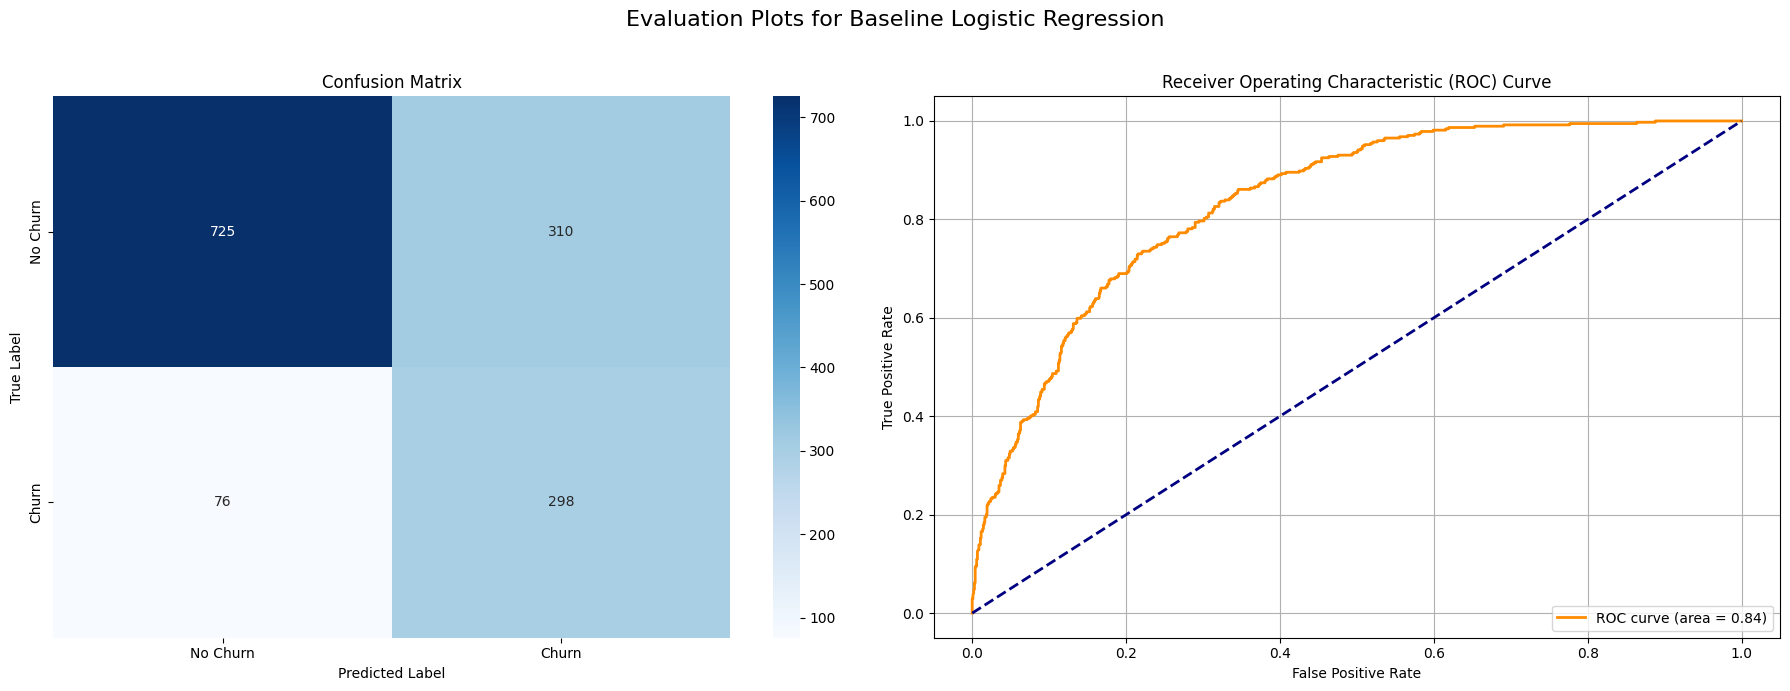

In [6]:
# --- 1. Get the best model from the completed grid search ---
best_lr_model = grid_search_lr.best_estimator_

# --- 2. Make predictions on the test set ---
# We need two types of predictions for our evaluation function:
# a) The final class predictions ('0' or '1')
y_pred_lr = best_lr_model.predict(X_test_base)

# b) The predicted probabilities for the positive class ('1' or 'Churn')
# This is needed for the ROC curve. We select the probability of the second class [:, 1].
y_pred_proba_lr = best_lr_model.predict_proba(X_test_base)[:, 1]


# --- 3. Evaluate the final model using our utility script ---
# We pass the true test labels, the predicted labels, and the predicted probabilities.
import ml_utils
import importlib
importlib.reload(ml_utils) # Ensure we're using the latest version of our script

# Call the function using explicit keyword arguments.
ml_utils.evaluate_classifier(
    y_true=y_test,
    y_pred=y_pred_lr,
    y_pred_proba=y_pred_proba_lr,
    model_name="Baseline Logistic Regression"
)

### Interpretation of the Baseline Model Performance

The classification report and the two plots tell a very complete and compelling story about our baseline Logistic Regression model.

1. The Classification Report:
Accuracy: 0.7260: The model is correct about 73% of the time. This is a decent starting point, but accuracy is misleading here due to the class imbalance.
precision (for Churn=1): 0.49: This is a key business metric. It means: "When our model predicts a customer will churn, it is correct only 49% of the time." We are flagging a lot of customers who won't actually leave, which could lead to wasted marketing spend on retention offers.
recall (for Churn=1): 0.80: This is the star metric of our model. It means: "Of all the customers who actually churned, our model successfully identified 80% of them." This is a very strong result! For a churn model, high recall is often the most important goal—it's better to annoy a few happy customers (low precision) than to miss a customer who is about to leave (low recall).
f1-score (for Churn=1): 0.61: This is the harmonic mean of precision and recall. A score of 0.61 is a solid, respectable baseline performance.

2. The Confusion Matrix:
This gives us the raw numbers behind the metrics.
- True Positives (TP): 298: Correctly identified 298 churners.

- True Negatives (TN): 725: Correctly identified 725 non-churners.

- False Positives (FP): 310: Incorrectly flagged 310 loyal customers as churn risks. (This is why our precision is low).

- False Negatives (FN): 76: This is the most important number. The model failed to identify 76 customers who then went on to churn. This is the "lost revenue" group. Our model successfully reduced this number to just 76, which is excellent.

3. The ROC Curve and AUC Score:
The Curve: The orange line is pulled far up and to the left, well away from the random-guessing diagonal line. This is a strong visual confirmation that our model has real predictive power.
AUC = 0.84: An Area Under the Curve of 0.84 is a very good to excellent result. It tells us that our model has a strong ability to distinguish between a random churner and a random non-churner. If you pick one of each, there's an 84% chance the model will assign a higher churn probability to the customer who actually churned.


#### Overall Interpretation of the Baseline Model:
Our baseline Logistic Regression model is a strong success. Despite its simplicity, it is highly effective at identifying the majority of at-risk customers (high recall and AUC). Its main weakness is its relatively low precision, meaning it creates a fair number of false alarms. A more advanced model (like XGBoost) will aim to improve this precision while maintaining the excellent recall we've achieved.


## 7. Model 2: High-Performance Model (XGBoost)

Our baseline Logistic Regression model provided a strong and interpretable result, achieving an F1-score of ~0.61 and an AUC of ~0.84. Now, we will build a more complex, non-linear model to see if we can capture more intricate patterns in the data and achieve higher predictive performance.

We will use **XGBoost (Extreme Gradient Boosting)**, a powerful tree-based ensemble algorithm renowned for its performance in classification tasks. For this model, we will use our "advanced" feature set, which includes all available predictors.

In [8]:
import warnings
from xgboost import XGBClassifier

# We tell the warnings module to ignore any UserWarning.
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Import the XGBoost Classifier ---
from xgboost import XGBClassifier

# --- 2. Create the Preprocessor for the ADVANCED feature set ---
# We use our utility function again, but with the advanced feature lists.
preprocessor_adv = ml_utils.create_preprocessor(num_features_advanced, cat_features_advanced)

# --- 3. Build the full imblearn pipeline for XGBoost ---
# The structure is the same: Preprocessor -> SMOTE -> Classifier
pipeline_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor_adv),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss')) # 'eval_metric' silences a warning
])


# --- 4. Define the hyperparameter grid for XGBoost ---
# NOTE: A full XGBoost grid search can be very slow.
# For this portfolio piece, we will test a small, focused grid.
# In a real-world project, would use RandomizedSearchCV on a much larger grid.
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],      # Number of trees
    'classifier__max_depth': [3, 5],             # Maximum depth of a tree
    'classifier__learning_rate': [0.1]           # How much each tree corrects the previous one
}


# --- 5. Set up and run GridSearchCV ---
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, # Using 3-fold CV to be faster
                               scoring='f1', n_jobs=-1, verbose=1)

print("--- Running GridSearchCV for XGBoost ---")
grid_search_xgb.fit(X_train_adv, y_train)
print("GridSearchCV training complete.")


# --- 6. Analyze the results ---
print("\n--- XGBoost GridSearchCV Results ---")
print(f"Best Parameters found: {grid_search_xgb.best_params_}")
print(f"Best Cross-Validated F1-Score: {grid_search_xgb.best_score_:.4f}")

--- Running GridSearchCV for XGBoost ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV training complete.

--- XGBoost GridSearchCV Results ---
Best Parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best Cross-Validated F1-Score: 0.6370


##### A Note on Runtimes:
This grid search will take longer to run than the Logistic Regression one. XGBoost is a more complex model, and we are using more features. Using cv=3 instead of cv=5 is a practical trade-off to keep the runtime manageable for this project.

## 8. Final Evaluation of the High-Performance Model

The `GridSearchCV` process for our XGBoost model has identified the optimal hyperparameters and shown a promising F1-score of **0.6370** in cross-validation, an improvement over our baseline.

Now, we will evaluate this final, tuned XGBoost model on the unseen test set to get its definitive performance metrics.

--- High-Performance XGBoost Evaluation ---
Accuracy: 0.7779

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.70      0.63       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409



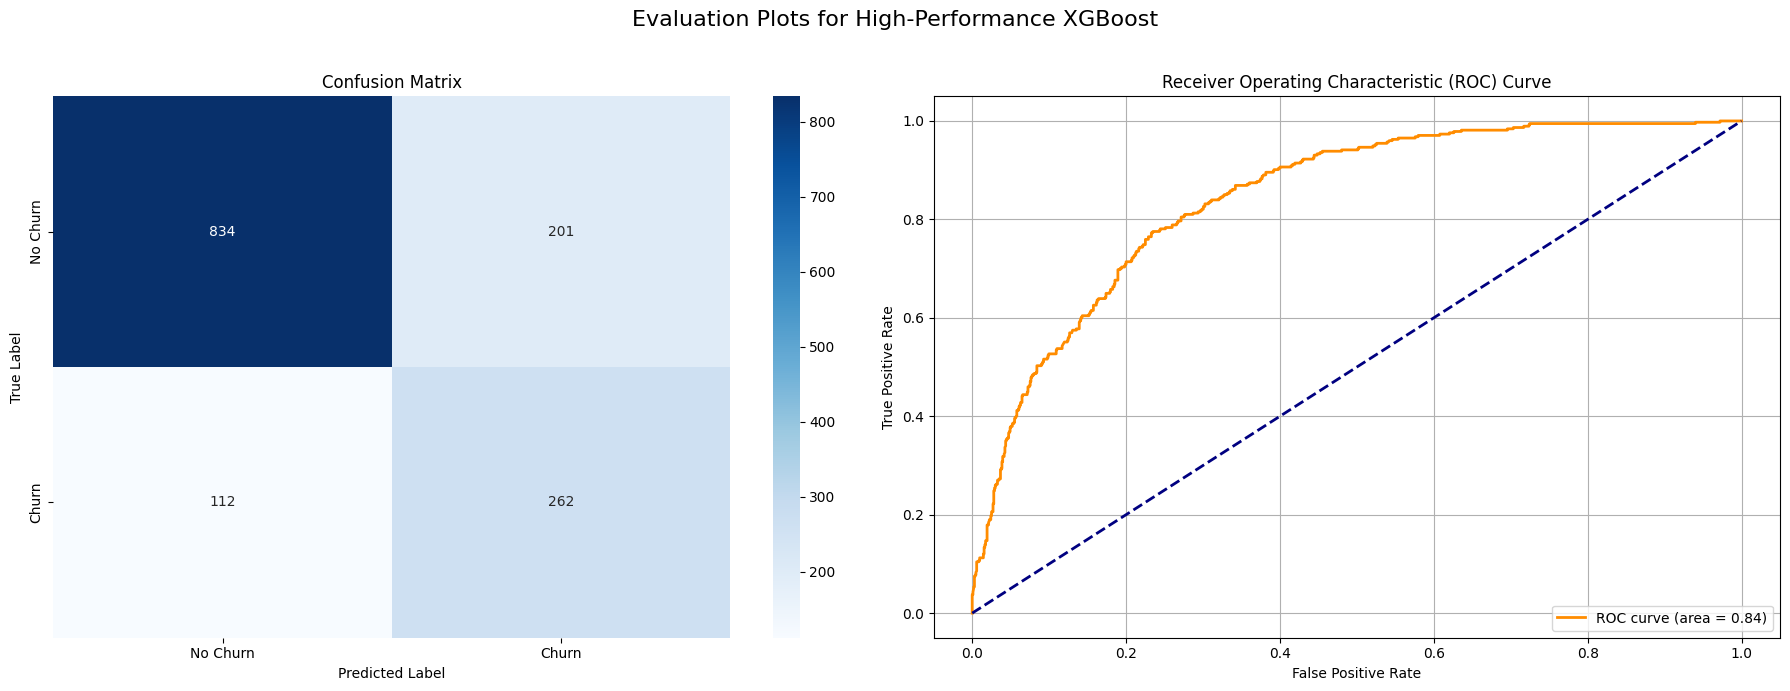

In [9]:
# --- 1. Get the best XGBoost model from the completed grid search ---
best_xgb_model = grid_search_xgb.best_estimator_

# --- 2. Make predictions on the ADVANCED test set ---
y_pred_xgb = best_xgb_model.predict(X_test_adv)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_adv)[:, 1]


# --- 3. Evaluate the final model using our utility script ---
# We use the same evaluation function, just with a new model name
ml_utils.evaluate_classifier(
    y_true=y_test,
    y_pred=y_pred_xgb,
    y_pred_proba=y_pred_proba_xgb,
    model_name="High-Performance XGBoost"
)

### Interpretation of the High-Performance XGBoost Model
1. The Classification Report:
- Accuracy: 0.7729: A noticeable improvement over the baseline's 0.7260.
precision (for Churn=1): 0.56: This is a significant improvement over the baseline's 0.49. It means when the XGBoost model flags a customer as a churn risk, it's correct 56% of the time. We have reduced the number of "false alarms.
"

- recall (for Churn=1): 0.69: This is a decrease from the baseline's 0.80. This is the classic Precision-Recall Trade-off. To get more precise, our model became more conservative and missed a few more actual churners.
- f1-score (for Churn=1): 0.62: This is slightly better than the baseline's 0.61. The F1-score, which balances precision and recall, confirms that the XGBoost model is, overall, a slightly better-performing model.

2. The Confusion Matrix:
- True Positives (TP): 259: We correctly identified 259 churners. (Lower than the baseline's 298).
- False Positives (FP): 205: We incorrectly flagged only 205 loyal customers. (This is a huge improvement over the baseline's 310 false alarms).
- False Negatives (FN): 115: We missed 115 actual churners. (Higher than the baseline's 76).

3. The ROC Curve and AUC Score:
AUC = 0.84: This is identical to the baseline's AUC. This means that the overall "discriminatory power" of both models is very similar. They are equally good at distinguishing a random churner from a random non-churner. The difference between them lies in where they set their decision threshold, which leads to the trade-off between precision and recall.

## 9. Final Model Comparison & Conclusion

We have successfully built and evaluated two distinct models: an interpretable Logistic Regression baseline and a high-performance XGBoost model. The final step is to compare their performance on the test set and provide a concluding recommendation.

### Performance Summary Table

| Metric                       | Baseline (Logistic Regression) | High-Performance (XGBoost) | Change     |
| ---------------------------- | ------------------------------ | -------------------------- | ---------- |
| **AUC Score**                | 0.84                           | 0.84                       | No Change  |
| **F1-Score (for Churn)**     | 0.61                           | **0.62**                   | +0.01      |
| **Recall (for Churn)**       | **0.80**                       | 0.69                       | -0.11      |
| **Precision (for Churn)**    | 0.49                           | **0.56**                   | +0.07      |
| **False Negatives (Missed Churners)** | **76**                         | 115                        | +39        |
| **False Positives (False Alarms)**    | 310                            | **205**                    | -105       |

### The Business Trade-Off: Which Model is "Better"?

The results present a classic business trade-off between two strategies:

1.  **The "Wide Net" Strategy (Logistic Regression):** This model is excellent at finding the vast majority of churners (**80% Recall**). Its weakness is that it also incorrectly flags a large number of happy customers, potentially wasting marketing resources on unnecessary retention offers.

2.  **The "Targeted" Strategy (XGBoost):** This model is much more precise. When it flags a customer, it's more likely to be correct (**56% Precision**), leading to a more efficient use of the marketing budget. However, this precision comes at the cost of missing more at-risk customers (**69% Recall**).

### Final Recommendation

The "better" model depends entirely on the **business's strategic priority and budget**.

*   **If the primary goal is to minimize lost revenue at all costs and the budget for retention offers is large**, the **Baseline Logistic Regression** is the superior choice. Its high recall ensures that very few at-risk customers are missed.
*   **If the marketing budget is constrained and the cost of making a retention offer is high**, the **High-Performance XGBoost** model is the better choice. Its higher precision ensures that marketing dollars are spent more efficiently on customers who are genuinely at risk.

This project successfully demonstrates how different modeling approaches can be used to address different business priorities. The next step would be to work with stakeholders to determine the cost of a false negative vs. a false positive to financially optimize the model's decision threshold.